## Effect of Inflation and Deficits on Interest Rates

In [263]:

import math
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
from IPython.display import Image
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt





In [264]:
def inspect_col_names(xls_name):
    #print data dictionary after file is loaded
    f = open('../../data/{0}.des'.format(xls_name), 'r')
    file_contents = f.read()
    print(file_contents)
    return None



In [265]:
inspect_col_names(xls_name='INTDEF')

INTDEF.DES

year      i3        inf       rec       out       def       i3_1      inf_1    
def_1     ci3       cinf      cdef      y77

  Obs:    49

  1. year                     1948-1996
  2. i3                       3 mo. T bill rate
  3. inf                      CPI inflation rate
  4. rec                      federal receipts, % GDP
  5. out                      federal outlays, % GDP
  6. def                      out - rec (deficit as % GDP)
  7. i3_1                     i3[t-1]
  8. inf_1                    inf[t-1]
  9. def_1                    def[t-1]
 10. ci3                      i3 - i3_1
 11. cinf                     inf - inf_1
 12. cdef                     def - def_1
 13. y77                      =1 year >= 1977; change in FY




In [266]:

def rename_cols_and_save(xls_name):
    df = pd.read_excel("../../data/{0}.xls".format(xls_name), index_col=None, header=None)
    if xls_name == 'hprice1':
        names_dict = {0:'price', 
                     1:'assess', 
                     2:'bdrms',
                     3:'lotsize', 
                     4:'sqrft', 
                     5:'colonial',
                     6:'lprice', 
                     7:'lassess', 
                     8:'llotsize',
                     9:'lsqrft', 
                    }
    elif xls_name == 'saving':
         names_dict = {0:'sav', 
                     1:'inc', 
                     2:'size',
                     3:'edu', 
                     4:'age', 
                     5:'black',
                     6:'cons', 
                      }
    elif xls_name == '401k':    
        names_dict = {0:'prate', 
                     1:'mrate', 
                     2:'totpart',
                     3:'totelg', 
                     4:'age', 
                     5:'totemp',
                     6:'sole', 
                     7:'ltotemp', 
                      }
        
    elif xls_name == '401ksubs': 
        names_dict = {0:'e401k', 
                     1:'inc', 
                     2:'marr',
                     3:'male', 
                     4:'age', 
                     5:'fsize',
                     6:'nettfa', 
                     7:'p401k',
                     8:'pira',
                     9:'incsq', 
                     10:'agesq',
                      }
    elif xls_name == 'INTDEF':
             names_dict = {0:'year', 
                     1:'i3', 
                     2:'inf',
                     3:'rec', 
                     4:'out', 
                     5:'def',
                     6:'i3_1', 
                     7:'inf_1',
                     8:'def_1',
                     9:'ci3', 
                     10:'cinf',
                     11:'cdef', 
                     12:'y77',
                      }
  
        
        
        
    df.rename(columns = names_dict, inplace = True)
    df.to_csv("../../data/{0}.csv".format(xls_name), index=False)
    
    
    return df

In [267]:
df = rename_cols_and_save(xls_name='INTDEF')
df.head()

,year,i3,inf,rec,out,def,i3_1,inf_1,def_1,ci3,cinf,cdef,y77
0,1948,1.04,8.1,16.4,11.7,-4.700000,.,.,.,.,.,.,0
1,1949,1.10,-1.2,14.6,14.4,-0.200001,1.04,8.1,-4.7,0.0600001,-9.3,4.5,0
2,1950,1.22,1.3,14.5,15.6,1.100000,1.1,-1.2,-0.200001,0.12,2.5,1.3,0
3,1951,1.55,7.9,16.1,14.2,-1.900001,1.22,1.3,1.1,0.33,6.6,-3,0
4,1952,1.77,1.9,18.9,19.4,0.500000,1.55,7.9,-1.9,0.22,-6,2.4,0


## Cleaing dataset

In [268]:
df = df.replace('.', pd.np.nan)
df.head()

,year,i3,inf,rec,out,def,i3_1,inf_1,def_1,ci3,cinf,cdef,y77
0,1948,1.04,8.1,16.4,11.7,-4.700000,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1949,1.10,-1.2,14.6,14.4,-0.200001,1.04,8.1,-4.700000,0.06,-9.3,4.499999,0
2,1950,1.22,1.3,14.5,15.6,1.100000,1.10,-1.2,-0.200001,0.12,2.5,1.300001,0
3,1951,1.55,7.9,16.1,14.2,-1.900001,1.22,1.3,1.100000,0.33,6.6,-3.000001,0
4,1952,1.77,1.9,18.9,19.4,0.500000,1.55,7.9,-1.900001,0.22,-6.0,2.400001,0


In [269]:
list_col_with_na = ['i3_1', 'inf_1', 'def_1', 'ci3', 'cinf', 'cdef']
for col in list_col_with_na:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.head()

,year,i3,inf,rec,out,def,i3_1,inf_1,def_1,ci3,cinf,cdef,y77
0,1948,1.04,8.1,16.4,11.7,-4.700000,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1949,1.10,-1.2,14.6,14.4,-0.200001,1.04,8.1,-4.700000,0.06,-9.3,4.499999,0
2,1950,1.22,1.3,14.5,15.6,1.100000,1.10,-1.2,-0.200001,0.12,2.5,1.300001,0
3,1951,1.55,7.9,16.1,14.2,-1.900001,1.22,1.3,1.100000,0.33,6.6,-3.000001,0
4,1952,1.77,1.9,18.9,19.4,0.500000,1.55,7.9,-1.900001,0.22,-6.0,2.400001,0


In [270]:
def to_bool(df, list_of_vars):
    for var in list_of_vars:
        df[var] = df[var].astype('bool')
    
    return df

In [271]:
bool_vars = ['y77']
df_clean = to_bool(df=df, list_of_vars=bool_vars)

In [272]:
class EDA(object):
    
    def __init__(self, df, y):
        self.df = df
        self.y_string = y
        self.y = df[y]
        return None
    
    
    def inspect(self):
        inspect = {}
        inspect['head'] = self.df.head()
        inspect['describe'] = self.df.describe().T
        inspect['dtypes'] = self.df.dtypes
        return inspect
        
        return inspect 
    
    def _dist_plot(self, df, var):
        plt.figure()
        sns_plot = sns.distplot(df[var].dropna(), color='b').get_figure()
        sns_plot.savefig("dist_plot_{0}.png".format(var))
        return sns_plot
    
    
    def variation(self):
        numerical = self.df.select_dtypes(include=np.number)
        for col in numerical.columns: 
            self._dist_plot(df=numerical, var=col)   
        return None
    
    
    def _scatter_matrix(self):
        numerical = self.df.select_dtypes(include=np.number)
        plt.figure()
        sns_plot = sns.pairplot(numerical)
        sns_plot.savefig("scatter_matrix_plot.png".format())
        return None
    
    def _box_plot(self, var_x):
        plt.figure()
        sns_plot = sns.boxplot(x=var_x, y=self.y, data=self.df).get_figure()
        sns_plot.savefig("box_plot_{0}_{1}.png".format(var_x, self.y_string))
        return None
    
    def _scatter_plot(self, var_x):
        sns_plot = sns.lmplot(x=var_x, y=self.y_string, data=self.df)
        sns_plot.savefig("correlation_{0}_{1}.png".format(var_x, self.y_string))
        return None
    
    def covariation(self):
        self._scatter_matrix()
        
        categorical = self.df.select_dtypes(include=['bool', 'category']) 
        for col in categorical.columns:
            self._box_plot(var_x = col)
         
        numerical = self.df.select_dtypes(include=np.number)
        for col in numerical.columns:
            self._scatter_plot(var_x=col)
        return None
    
    def run(self):
        self.variation()
        self.covariation()
        return None
    
    pass

In [273]:
my_eda = EDA(df_clean, y='i3')

In [274]:
my_eda.inspect()['head']

,year,i3,inf,rec,out,def,i3_1,inf_1,def_1,ci3,cinf,cdef,y77
0,1948,1.04,8.1,16.4,11.7,-4.700000,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1949,1.10,-1.2,14.6,14.4,-0.200001,1.04,8.1,-4.700000,0.06,-9.3,4.499999,False
2,1950,1.22,1.3,14.5,15.6,1.100000,1.10,-1.2,-0.200001,0.12,2.5,1.300001,False
3,1951,1.55,7.9,16.1,14.2,-1.900001,1.22,1.3,1.100000,0.33,6.6,-3.000001,False
4,1952,1.77,1.9,18.9,19.4,0.500000,1.55,7.9,-1.900001,0.22,-6.0,2.400001,False


In [275]:
my_eda.inspect()['describe']

,count,mean,std,min,25%,50%,75%,max
year,49.0,1972.000000,14.288690,1948.000000,1960.000000,1972.000000,1984.0000,1996.000000
i3,49.0,5.068980,2.965661,0.950000,2.930000,4.880000,6.6900,14.030000
inf,49.0,4.108163,3.182821,-1.200000,1.700000,3.200000,5.7000,13.500000
rec,49.0,17.838776,1.058855,14.500000,17.500000,17.800000,18.5000,19.700000
out,49.0,19.691837,2.514528,11.700000,18.500000,19.600000,21.5000,23.600000
def,49.0,1.853061,2.042680,-4.700000,0.500000,1.699999,3.1000,6.000000
i3_1,48.0,5.070000,2.997035,0.950000,2.892500,4.615000,6.7775,14.030000
inf_1,48.0,4.131250,3.212354,-1.200000,1.675000,3.250000,5.7250,13.500000
def_1,48.0,1.862500,2.063216,-4.700000,0.500000,1.850000,3.1250,6.000000
ci3,48.0,0.082917,1.381285,-3.340000,-0.572500,0.250000,0.9350,2.970000


In [276]:
my_eda.inspect()['dtypes']

year       int64
i3       float64
inf      float64
rec      float64
out      float64
def      float64
i3_1     float64
inf_1    float64
def_1    float64
ci3      float64
cinf     float64
cdef     float64
y77         bool
dtype: object

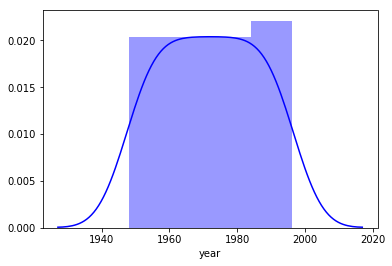

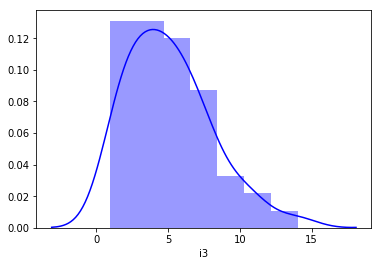

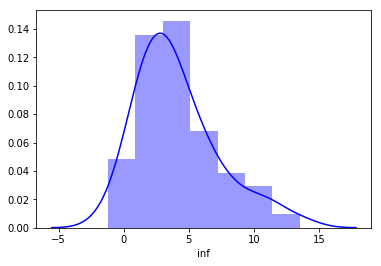

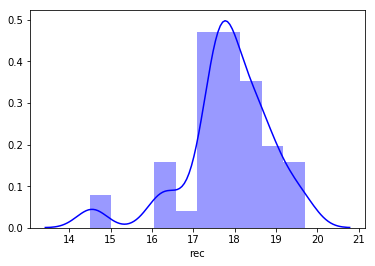

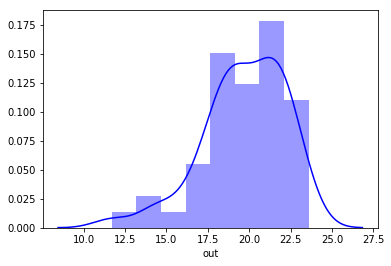

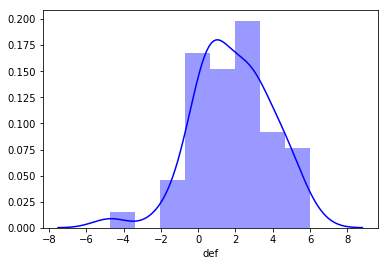

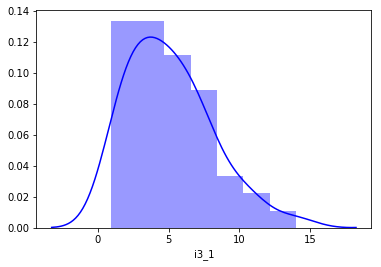

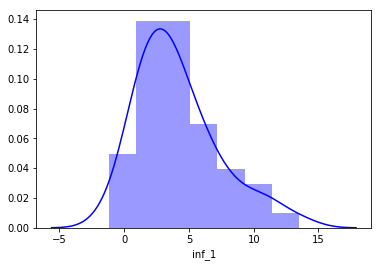

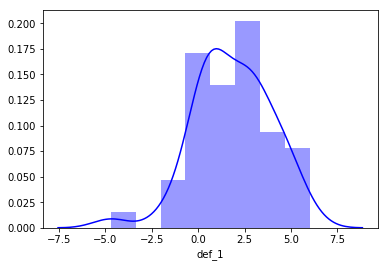

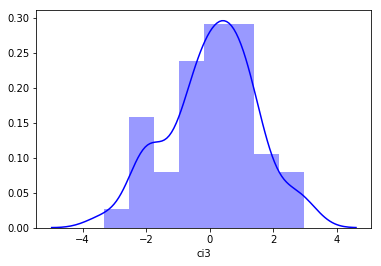

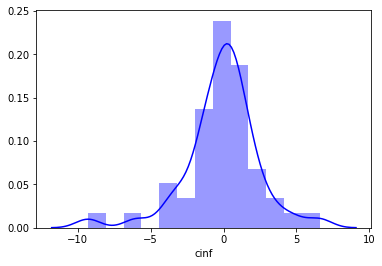

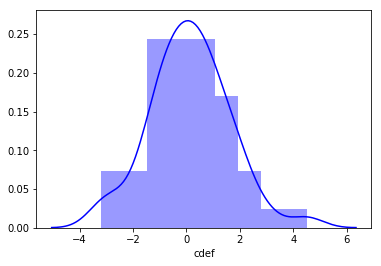

<Figure size 432x288 with 0 Axes>

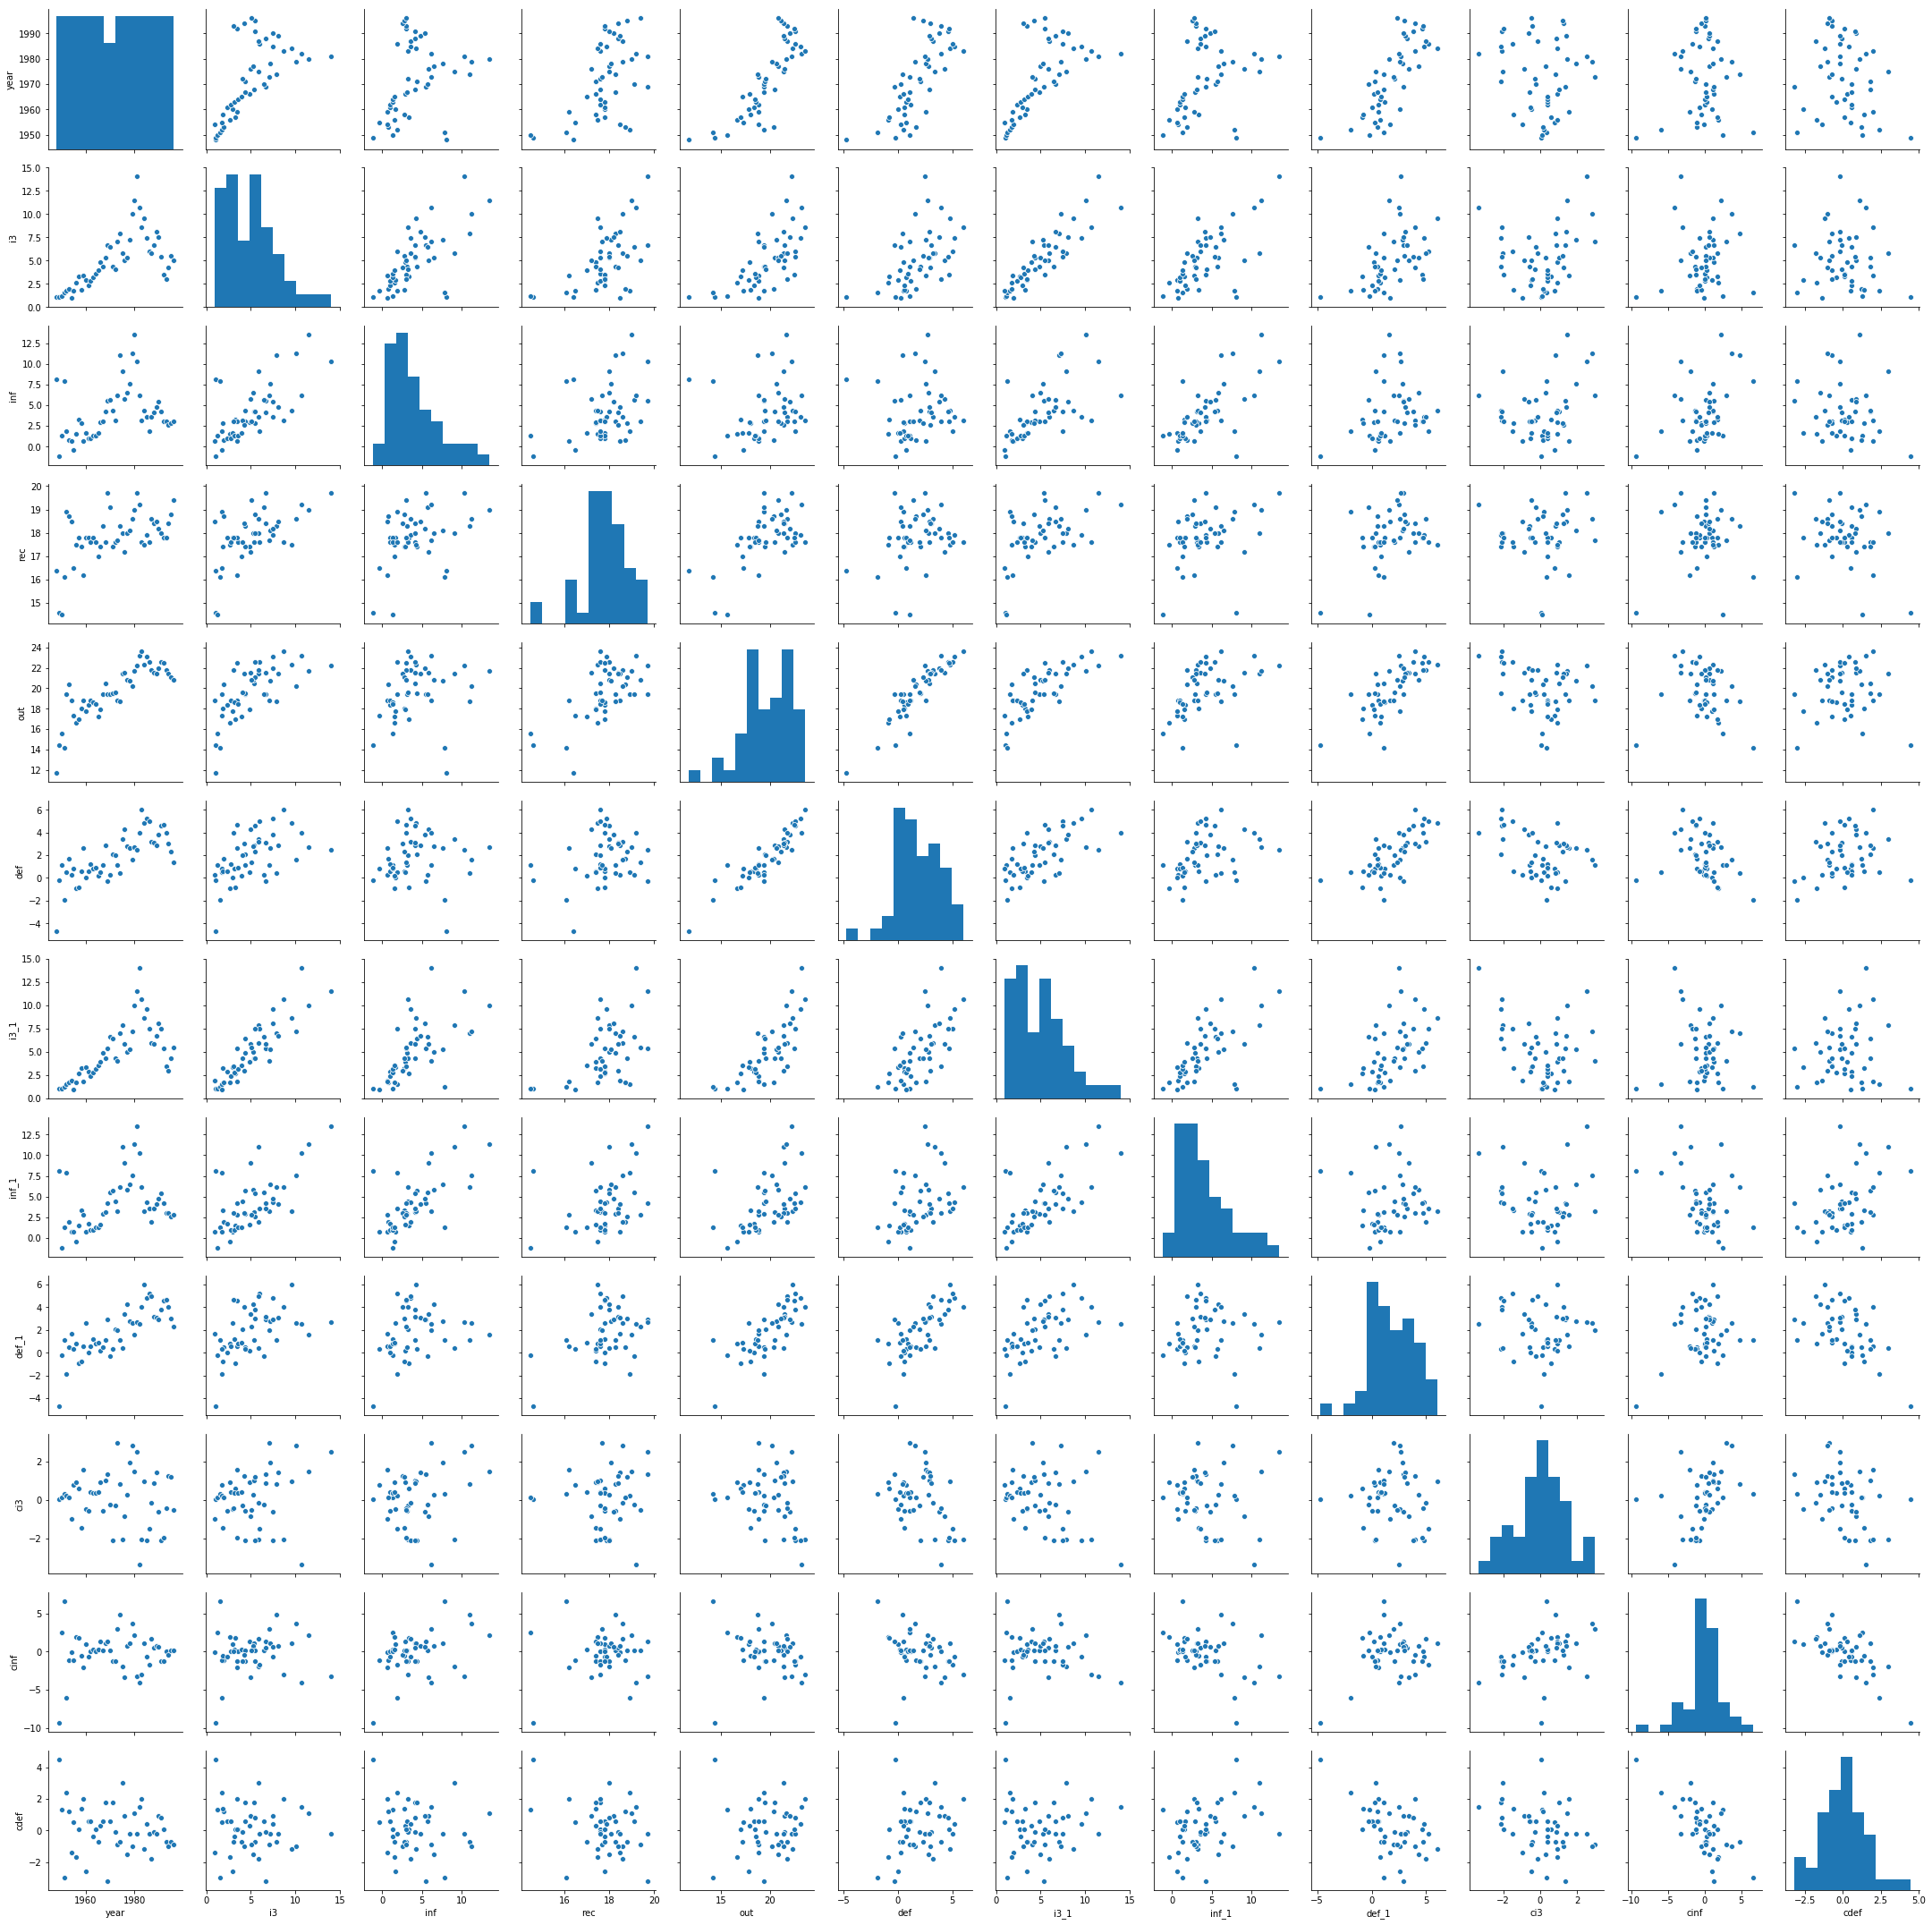

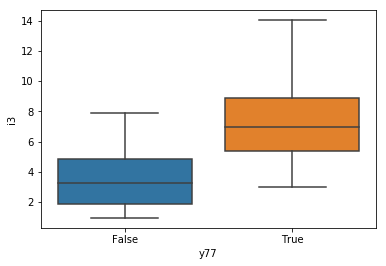

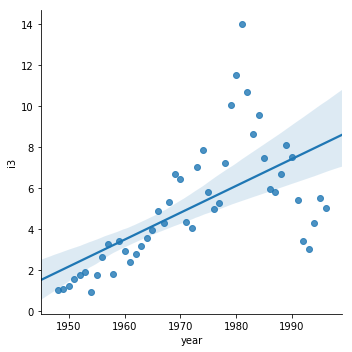

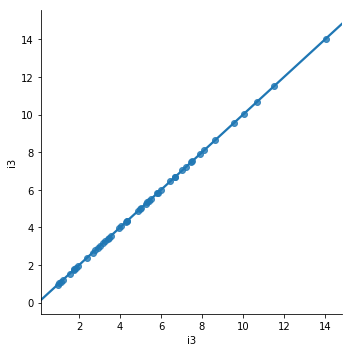

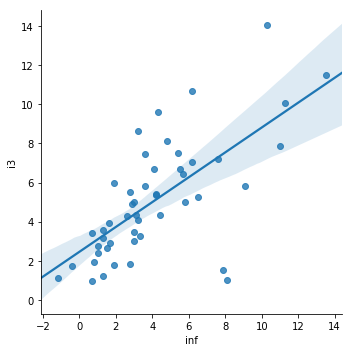

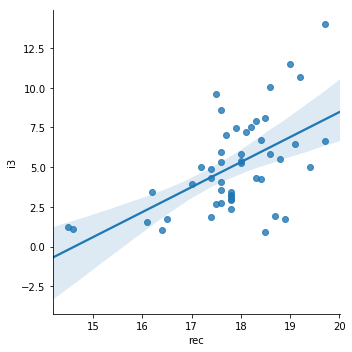

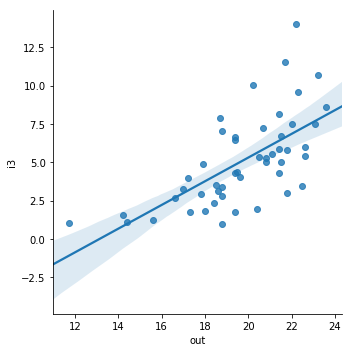

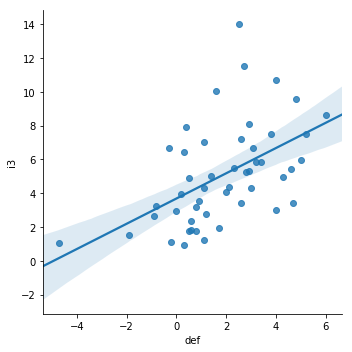

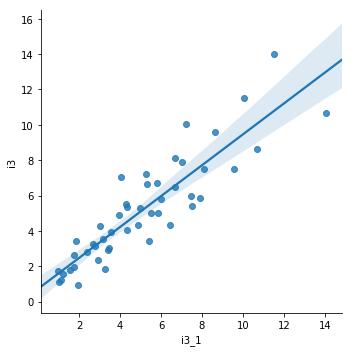

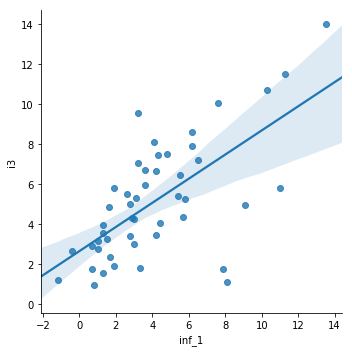

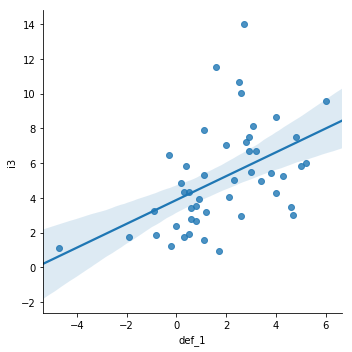

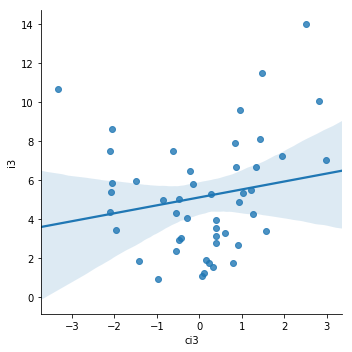

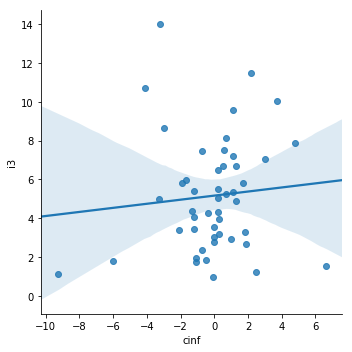

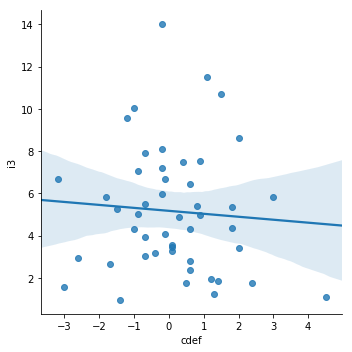

In [277]:
my_eda.run()

## Regression Model

In [278]:
class Regression(object):
    
    def __init__(self, df, formula, formula_final):
        self.df = df
        self.formula = formula
        self.formula_final = formula_final
        return None
    
    def _regressions(self, formula, data):
        models = {}
        models['res_ols'] = smf.ols(formula=formula, data=data).fit().summary()
        models['res_reg_ridge']  = smf.ols(formula=formula, data=data).fit_regularized(method='elastic_net', alpha=0, L1_wt=1.0).params
        models['res_reg_lasso']  = smf.ols(formula=formula, data=data).fit_regularized(method='elastic_net', alpha=1, L1_wt=1.0).params
        return models

    def _final_regression(self, formula_final, data):
        final_model = smf.ols(formula=formula_final, data=data).fit().summary()
        return final_model
    
    def run(self):
        all_models = {}
        all_models['candidate_models'] = self._regressions(formula=self.formula, data=self.df)
        all_models['final_model'] = self._final_regression(formula_final=self.formula_final, data=self.df)
        return all_models



In [280]:
my_regression = Regression(df = df_clean, 
                       formula = "i3 ~ Q('inf') + Q('def') + y77", 
                       formula_final = "i3 ~ Q('inf') + Q('def')"
                          )



In [281]:
my_regression.run()

{'candidate_models': {'res_ols': <class 'statsmodels.iolib.summary.Summary'>
  """
                              OLS Regression Results                            
  Dep. Variable:                     i3   R-squared:                       0.716
  Model:                            OLS   Adj. R-squared:                  0.697
  Method:                 Least Squares   F-statistic:                     37.83
  Date:                Sat, 04 Apr 2020   Prob (F-statistic):           2.31e-12
  Time:                        19:32:41   Log-Likelihood:                -91.445
  No. Observations:                  49   AIC:                             190.9
  Df Residuals:                      45   BIC:                             198.5
  Df Model:                           3                                         
  Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
  -----------------------

## Candidate Model

In [282]:
candidate = smf.ols(formula="i3 ~ Q('inf') + Q('def')", data=df_clean).fit()
candidate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     i3   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     52.78
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           1.23e-12
Time:                        19:32:41   Log-Likelihood:                -93.079
No. Observations:                  49   AIC:                             192.2
Df Residuals:                      46   BIC:                             197.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2520      0.442      2.835      0.007       0.363       2.141
Q('inf')       0.6132      0.076      8.092      0.000       0.461       0.766
Q('def')       0.7004      0.118      5.932      0.000       0.463       0.938
==============================================================================
Omnibus:                        1.042   Durbin-Watson:                   0.914
Prob(Omnibus):                  0.594   Jarque-Bera (JB):                0.357
Skew:                           0.020   Prob(JB):                        0.836
Kurtosis:                       3.416   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Diagnostics

In [283]:
def outliers(model_fit):
    results = {}
    
    obs_influence = OLSInfluence(model_fit)
    summary_frame = obs_influence.summary_frame()
    obs_influence = summary_frame
    
    my_eda_influence = EDA(df=obs_influence, y='cooks_d')
    my_eda_influence.run()
    
    n = len(obs_influence.index)
    k = len(['inc', 'age', 'fsize', 'p401k', 'pira', 'incsq' , 'agesq'])
    print("INFO: Finding obs with high Cook's d")
    high_cooks_d = obs_influence[obs_influence['cooks_d'] > 4/n]
    
    print("INFO: Finding obs with high DFfits")
    large_dffits = obs_influence[obs_influence['dffits'].abs() > (2 * math.sqrt(k/n))] 
    
    print("INFO: Finding obs with high dfbetas")
    dfb_cols = [col for col in obs_influence.columns if 'dfb' in col]
    dfb_frames = [obs_influence[obs_influence[col].abs() > (2 / math.sqrt(n))] for col in dfb_cols ]
    dfb_merged = dfb_frames[0]
    for df in dfb_frames[1:]:
        dfb_merged = pd.merge(dfb_merged, df, how='inner')  
    final_influential_observations = [high_cooks_d, large_dffits, dfb_merged]
    final_merge = final_influential_observations[0]
    for df in final_influential_observations[1:]:
        final_merge = pd.merge(final_merge, df, how='inner') 
    
    print("INFO: Outliers dataframe")
    results['outliers'] = final_merge
    df_final = df_clean.merge(final_merge, left_index=True, right_index=True, how='left', indicator=True)
    
    print("INFO: Dataframe without outliers")
    results['df_no_outliers'] = df_final[df_final['_merge'] == 'left_only']
    
    return results


def normality_of_residuals(model_fit):
    print("INTERPRETATION: if Chi^2 two-tail prob. < .10 then the residuals are NOT normally distributed")
    name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
    test = sms.jarque_bera(model_fit.resid)
    return lzip(name, test)

    
def multicollinearity(X):
    print("INTERPRETATION: VIF Factor larger than 10 this feature is multicollinear")
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif


def run(model_fit, X, final_formula):
    diagnostics = {}
    
    df_no_outliers = outliers(model_fit=model_fit)['df_no_outliers']
    
    X = df_clean[X]
    X = X.select_dtypes(include=np.number)
    
    diagnostics['multicollinearity'] = multicollinearity(X=X)
    diagnostics['normality_of_residuals'] = normality_of_residuals(model_fit=candidate_no_outliers)
    diagnostics['model'] = smf.ols(formula=final_formula, data=df_no_outliers).fit().summary()
    diagnostics['df_no_outliers'] = df_no_outliers

    return diagnostics


INFO: Finding obs with high Cook's d
INFO: Finding obs with high DFfits
INFO: Finding obs with high dfbetas
INFO: Outliers dataframe
INFO: Dataframe without outliers
INTERPRETATION: VIF Factor larger than 10 this feature is multicollinear
INTERPRETATION: if Chi^2 two-tail prob. < .10 then the residuals are NOT normally distributed


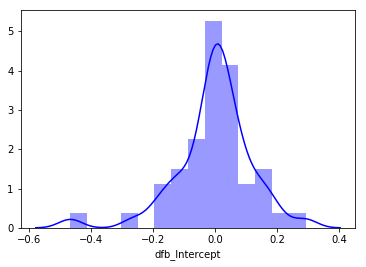

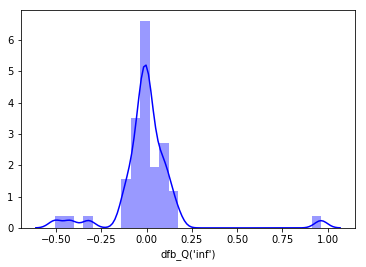

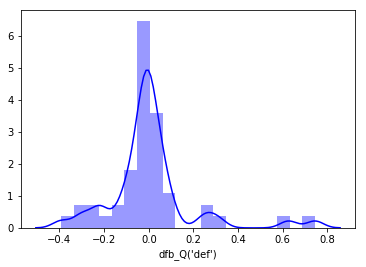

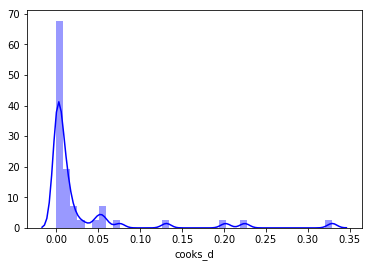

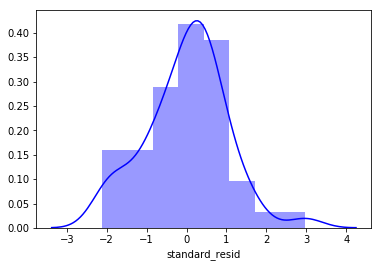

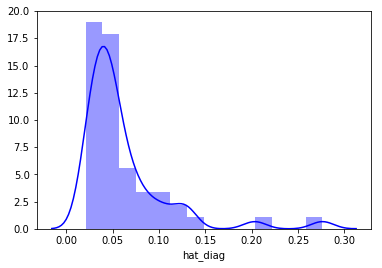

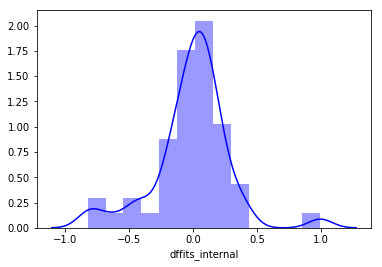

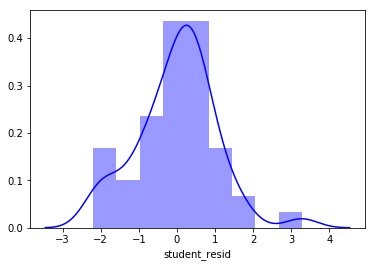

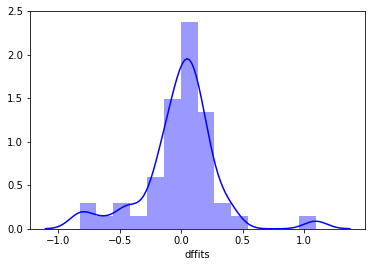

<Figure size 432x288 with 0 Axes>

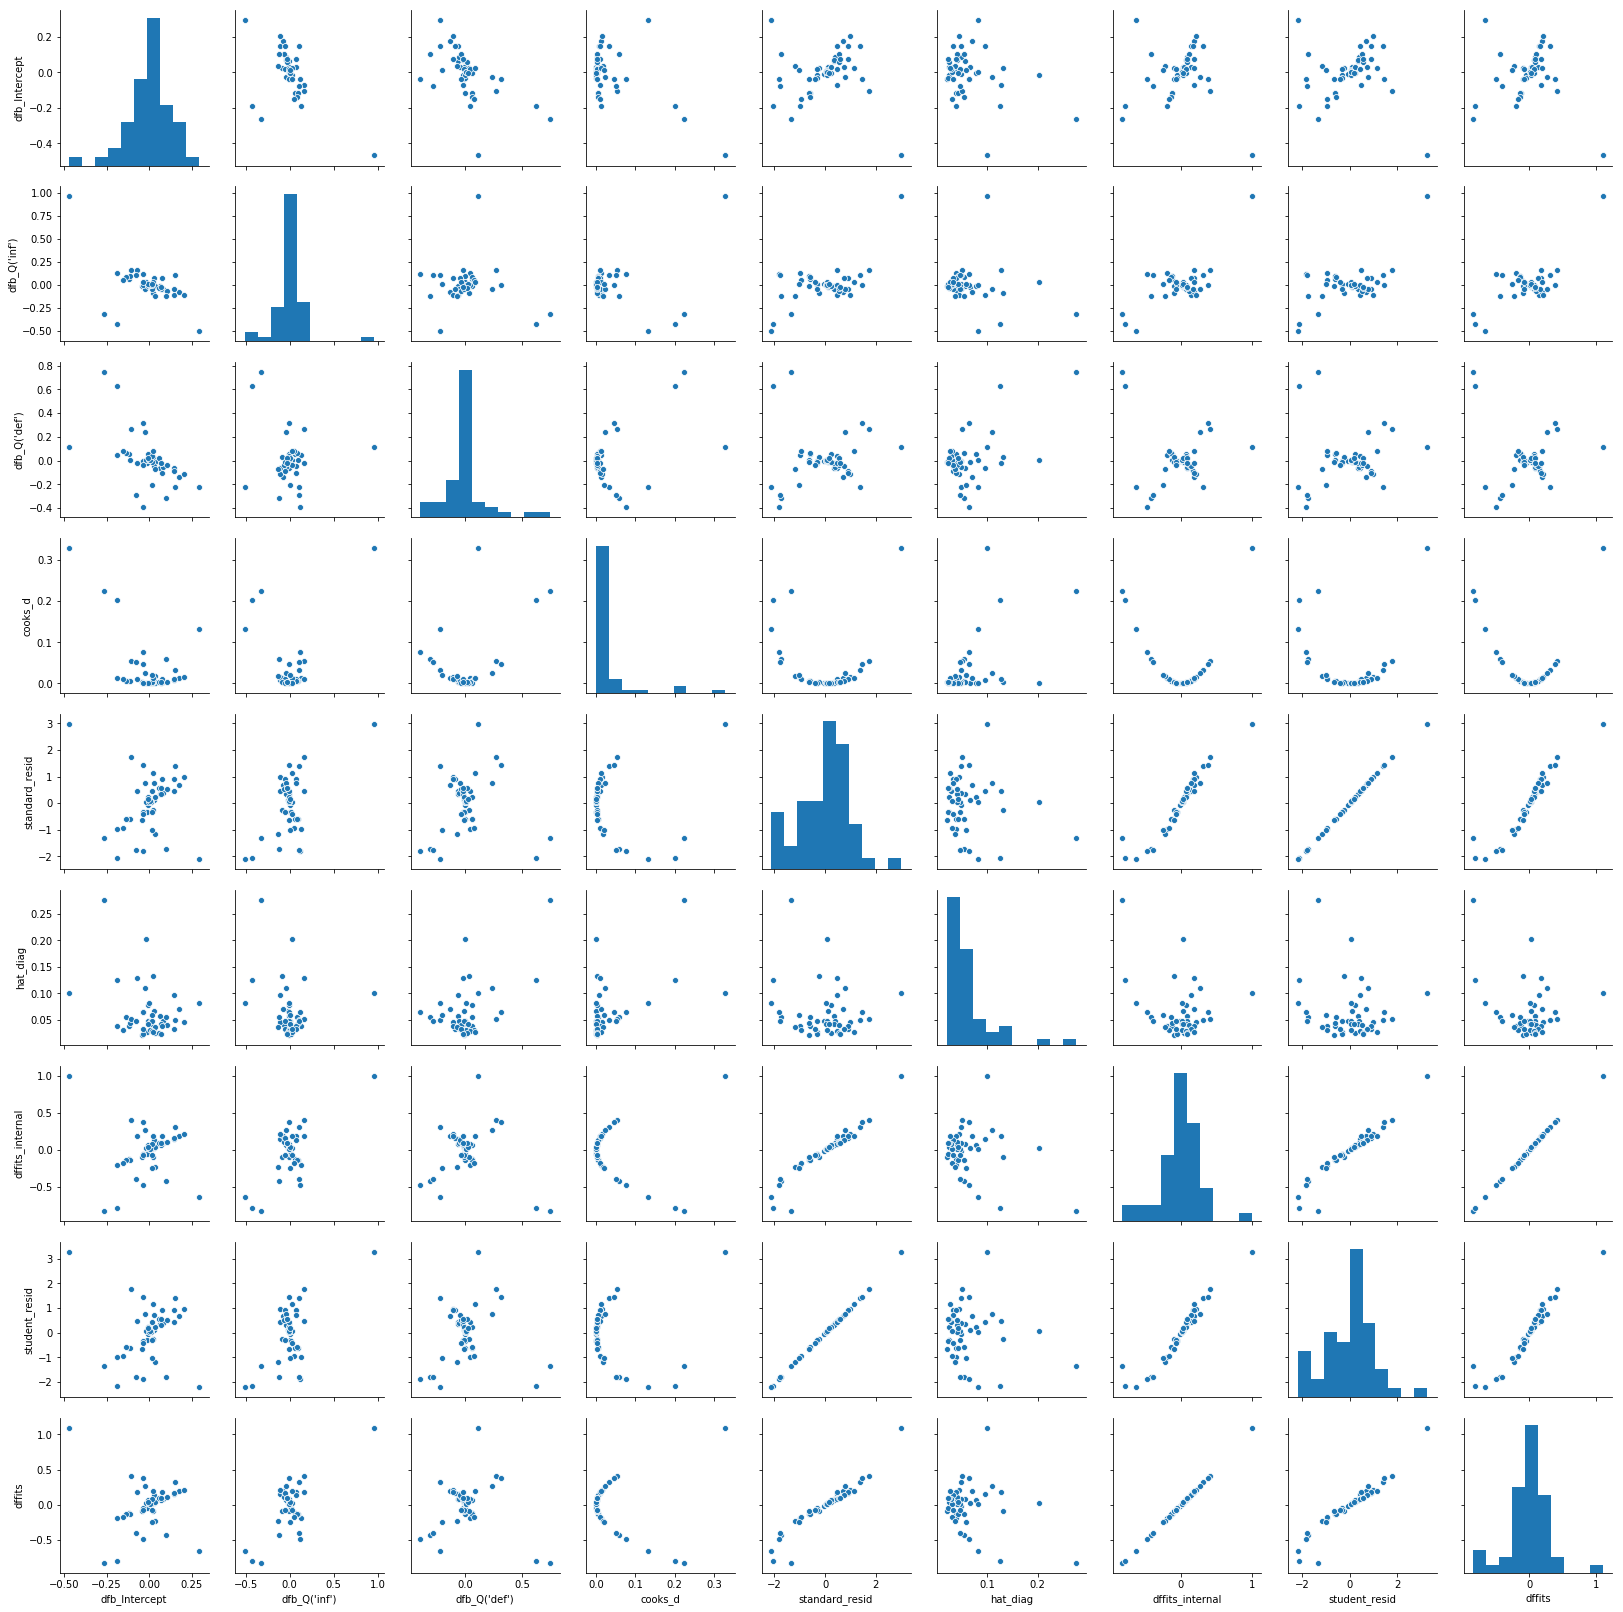

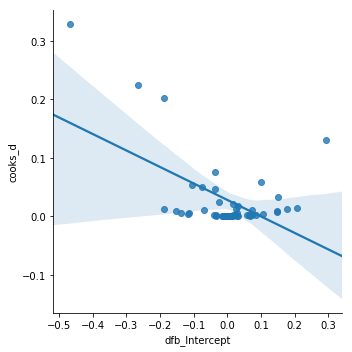

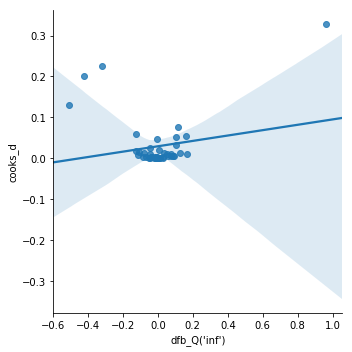

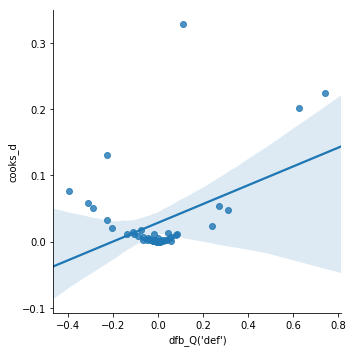

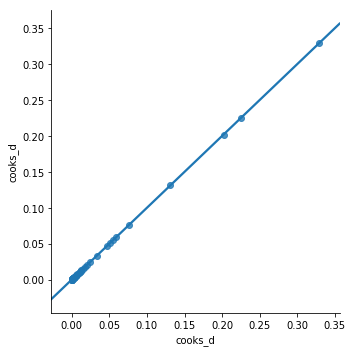

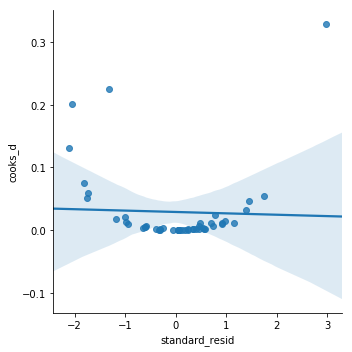

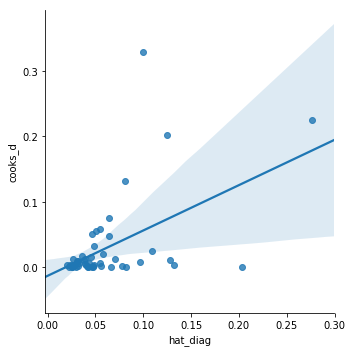

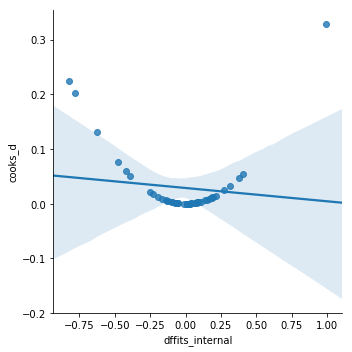

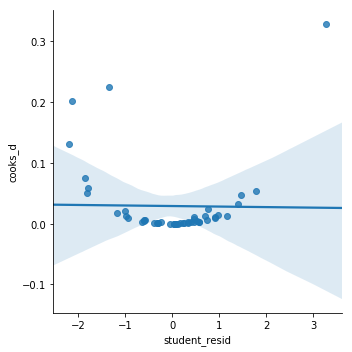

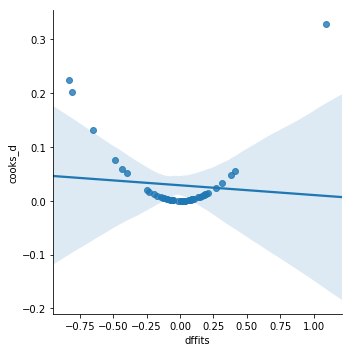

In [286]:
diagostics = run(model_fit=candidate, X=['inf', 'def'], final_formula="i3 ~ Q('inf') + Q('def')")

In [287]:
diagostics['model']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     i3   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     52.78
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           1.23e-12
Time:                        19:41:15   Log-Likelihood:                -93.079
No. Observations:                  49   AIC:                             192.2
Df Residuals:                      46   BIC:                             197.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2520      0.442      2.835      0.007       0.363       2.141
Q('inf')       0.6132      0.076      8.092      0.000       0.461       0.766
Q('def')       0.7004      0.118      5.932      0.000       0.463       0.938
==============================================================================
Omnibus:                        1.042   Durbin-Watson:                   0.914
Prob(Omnibus):                  0.594   Jarque-Bera (JB):                0.357
Skew:                           0.020   Prob(JB):                        0.836
Kurtosis:                       3.416   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""